In [1]:
import numpy as np
import pandas as pd
import bloscpack as bp

from sklearn.model_selection import StratifiedKFold

import imgaug as ia
import imgaug.augmenters as iaa

from torch.utils.data.dataloader import DataLoader

import fastai
from fastai.vision import *

from optim import Over9000
from data import Bengaliai_DS, Bengaliai_DS_LIT
from model import *
from model_utils import *
from utils import *

---

In [2]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

---
### data

In [3]:
pdf = pd.read_csv('../input/train.csv')
unique_grapheme = pdf['grapheme'].unique()
grapheme_code = dict([(g, c) for g, c in zip(unique_grapheme, np.arange(unique_grapheme.shape[0]))])
pdf['grapheme_code'] = [grapheme_code[g] for g in pdf['grapheme']]

skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
for trn_ndx, vld_ndx in skf.split(pdf['grapheme_code'], pdf['grapheme_code']):
    break
    
imgs = bp.unpack_ndarray_from_file('../features/train_images_size168_pad6.bloscpack')
lbls = pd.read_csv('../input/train.csv').iloc[:, 1:4].values

trn_imgs = imgs[trn_ndx]
trn_lbls = lbls[trn_ndx]
vld_imgs = imgs[vld_ndx]
vld_lbls = lbls[vld_ndx]

In [4]:
batch_size = 64 # 64 is important as the fit_one_cycle arguments are probably tuned for this batch size

# training_set = Bengaliai_DS(trn_imgs, trn_lbls, transform=augs)
validation_set = Bengaliai_DS(vld_imgs, vld_lbls)

# training_loader = DataLoader(training_set, batch_size=batch_size, num_workers=6, shuffle=True) # , sampler=sampler , shuffle=True
validation_loader = DataLoader(validation_set, batch_size=batch_size, num_workers=6, shuffle=False)

# data_bunch = DataBunch(train_dl=training_loader, valid_dl=validation_loader)

---
### model

In [5]:
device = 'cuda:0'
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant

In [6]:
predictor = PretrainedCNN(out_dim=n_total)
classifier = BengaliClassifier(predictor).to(device)

In [7]:
weight = torch.load('./outputs/Seresnext50_Size168_BestAug_Nosplitmodel_Nowd_CmMu_1of7.pth')
classifier.load_state_dict(weight)

<All keys matched successfully>

In [8]:
ndcs = []
preds_g, preds_v, preds_c, = [], [], []
lbls_g, lbls_v, lbls_c, = [], [], []

with torch.no_grad():
    for i, (img, lbl) in enumerate(validation_loader):
        ndcs += np.arange(i*batch_size, (i+1)*batch_size).tolist()
        
        out_graph, out_vowel, out_conso = classifier(img.to(device))
        out_graph = F.softmax(out_graph, dim=1).data.cpu().numpy().argmax(axis=1)
        preds_g += out_graph.tolist()
        out_vowel = F.softmax(out_vowel, dim=1).data.cpu().numpy().argmax(axis=1)
        preds_v += out_vowel.tolist()
        out_conso = F.softmax(out_conso, dim=1).data.cpu().numpy().argmax(axis=1)
        preds_c += out_conso.tolist()
        
        lbl = lbl.numpy()
        lbls_g += lbl[:, 0].tolist()
        lbls_v += lbl[:, 1].tolist()
        lbls_c += lbl[:, 2].tolist()
        
        display_progress(len(validation_loader), i+1)

449/449 batches: 

---
### grapheme_root analysis

In [19]:
print(preds_g[:10])
print(lbls_g[:10])

[79, 23, 61, 81, 127, 115, 83, 107, 118, 29]
[79, 23, 61, 81, 127, 115, 83, 107, 118, 29]


In [85]:
error_ndces = [j for j, (p, l) in enumerate(zip(preds_g, lbls_g)) if p != l]
len(error_ndces)

871

In [104]:
errors = [preds_g[j] for j in error_ndces]
truths4errors = [lbls_g[j] for j in error_ndces]

In [109]:
errors, error_counts = np.unique(errors, return_counts=True)

In [127]:
errors

array([  3,   4,   6,   7, ..., 161, 162, 164, 167])

In [166]:
err_ndx = 202
err_img, err_lbl = vld_imgs[error_ndces[err_ndx]], vld_lbls[error_ndces[err_ndx]]
print(preds_g[error_ndces[err_ndx]], err_lbl)
crr_g_ndx = preds_g[error_ndces[err_ndx]]
err_g_ndx, v_ndx, c_ndx = err_lbl

84 [55  0  0]


In [167]:
similar_crr_images = vld_imgs[(vld_lbls[:, 0] == crr_g_ndx) & (vld_lbls[:, 1] == v_ndx) & (vld_lbls[:, 2] == c_ndx)]
print(similar_crr_images.shape)
similar_err_images = vld_imgs[(vld_lbls[:, 0] == err_g_ndx) & (vld_lbls[:, 1] == v_ndx) & (vld_lbls[:, 2] ==c_ndx)]
print(similar_err_images.shape)

(21, 168, 168)
(23, 168, 168)


Text(0.5, 1.0, 'similar correct image')

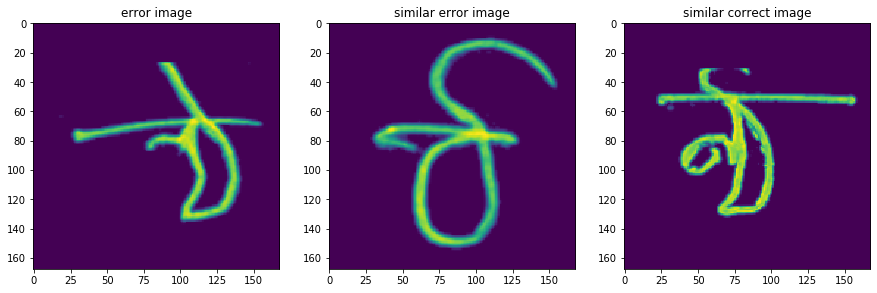

In [170]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))
show_similar_ndx = 3
ax[0].imshow(err_img)
ax[0].set_title('error image')
ax[1].imshow(similar_err_images[show_similar_ndx])
ax[1].set_title('similar error image')
ax[2].imshow(similar_crr_images[show_similar_ndx])
ax[2].set_title('similar correct image')

In [149]:
pdf.loc[(pdf['grapheme_root'] == crr_g_ndx) & (pdf['vowel_diacritic'] == v_ndx) & (pdf['consonant_diacritic'] == c_ndx)]

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,grapheme_code
1620,Train_1620,76,2,0,দ্বি,922
1905,Train_1905,76,2,0,দ্বি,922
3933,Train_3933,76,2,0,দ্বি,922
5160,Train_5160,76,2,0,দ্বি,922
6463,Train_6463,76,2,0,দ্বি,922
...,...,...,...,...,...,...
199253,Train_199253,76,2,0,দ্বি,922
199361,Train_199361,76,2,0,দ্বি,922
199611,Train_199611,76,2,0,দ্বি,922
200074,Train_200074,76,2,0,দ্বি,922


In [150]:
pdf.loc[(pdf['grapheme_root'] == err_g_ndx) & (pdf['vowel_diacritic'] == v_ndx) & (pdf['consonant_diacritic'] == c_ndx)]

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,grapheme_code
748,Train_748,75,2,0,দ্ধি,568
1241,Train_1241,75,2,0,দ্ধি,568
1435,Train_1435,75,2,0,দ্ধি,568
2995,Train_2995,75,2,0,দ্ধি,568
6376,Train_6376,75,2,0,দ্ধি,568
...,...,...,...,...,...,...
194530,Train_194530,75,2,0,দ্ধি,568
196869,Train_196869,75,2,0,দ্ধি,568
197299,Train_197299,75,2,0,দ্ধি,568
197327,Train_197327,75,2,0,দ্ধি,568


In [143]:
list(pdf.loc[(pdf['grapheme_root'] == crr_g_ndx) & (pdf['vowel_diacritic'] == v_ndx) & (pdf['consonant_diacritic'] == c_ndx), 'grapheme'].iloc[0])

['ঘ', '্', 'র', 'া']

In [144]:
list(pdf.loc[(pdf['grapheme_root'] == err_g_ndx) & (pdf['vowel_diacritic'] == v_ndx) & (pdf['consonant_diacritic'] == c_ndx), 'grapheme'].iloc[0])

['স', '্', 'র', 'া']